In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import random
import collections 
from collections import defaultdict, deque

In [6]:
def differential_q_learning(env,
                            num_iterations=1000,
                            alpha=0.1,
                            beta=0.01,
                            epsilon=0.1):

    Q   = collections.defaultdict(float)
    rho = 0.0

    # start
    raw = env.reset()
    state = tuple(raw)

    for _ in range(num_iterations):
        # ε‑greedy action selection
        actions = env.get_actions(state)
        if random.random() < epsilon:
            a = random.choice(actions)
        else:
            a = max(actions, key=lambda x: Q[(state, x)])

        # take action
        next_raw, reward, done, info = env.step(a)
        next_state = tuple(next_raw)

        # compute max_a' Q(next_state, a')
        next_actions = env.get_actions(next_state)
        max_q_next = max((Q[(next_state, a2)] for a2 in next_actions), default=0.0)

        # TD error: δ = r − ρ + max Q(next) − Q(state,action)
        delta = reward - rho + max_q_next - Q[(state, a)]

        # updates
        Q[(state, a)] += alpha * delta
        rho           += beta  * delta

        # advance
        state = next_state

    return Q, rho

In [31]:
from explicit2py_converter import ExplicitMDPEnv
env = ExplicitMDPEnv(
    tra_path="/Users/cancetinsoy/mdptest/access_control-automated.tra",
    rew_path="/Users/cancetinsoy/mdptest/access_control-automated.tra.rew",
    lab_path="/Users/cancetinsoy/mdptest/access_control-automated.lab",
    seed=0,  # optional
)

# plug straight into your differential_q_learning(...)
Q, rho = differential_q_learning(env, num_iterations=200000, alpha=0.1, beta=0.001, epsilon=0.1)
print(rho)  # learned average reward estimate

0.0


diffql done on access_control-automated. wrote diffql_results_access_control-automated.csv
[access_control-automated] empirical rho: mean=0.000000, std=0.000000, min=0.000000, max=0.000000
[access_control-automated] internal  rho: mean=0.000000, std=0.000000


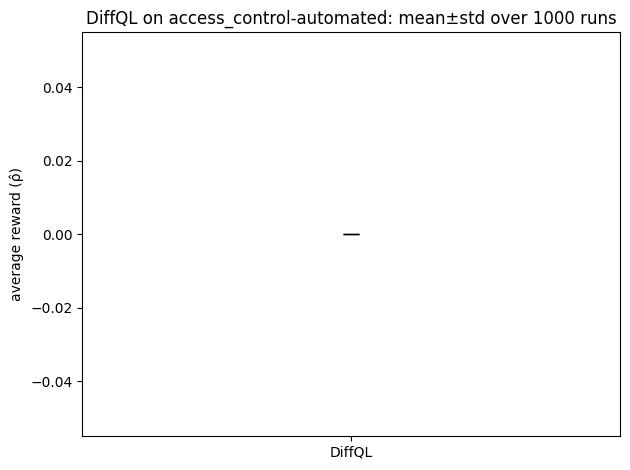

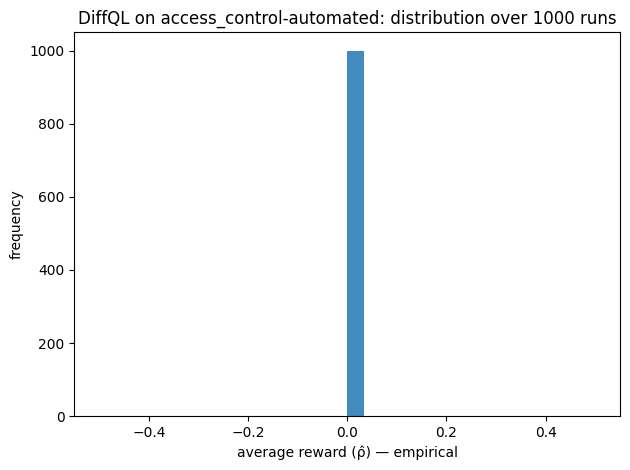

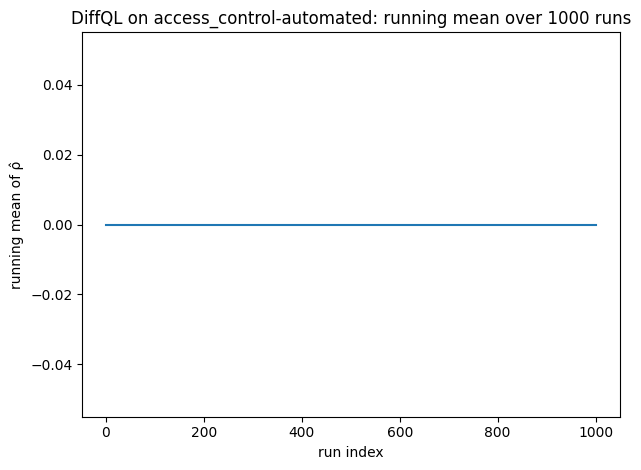

In [33]:
# ==== config ====
TRA_PATH = "/Users/cancetinsoy/mdptest/access_control-automated.tra"
REW_PATH = "/Users/cancetinsoy/mdptest/access_control-automated.tra.rew"
LAB_PATH = "/Users/cancetinsoy/mdptest/access_control-automated.lab"

NUM_RUNS = 1000
NUM_ITERATIONS = 200_000      # training iterations per run
ALPHA = 0.1
BETA = 0.001                  # rho step (eta * alpha in the paper)
EPSILON = 0.1

ROLLOUT_STEPS = 50_000        # for empirical rho
ROLLOUT_BURNIN = 5_000

# ==== imports ====
import os, csv, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from explicit2py_converter import ExplicitMDPEnv

# derive mdp name for titles + filenames
MDP_NAME = Path(TRA_PATH).stem

SAVE_CSV  = f"diffql_results_{MDP_NAME}.csv"
PLOT_BAR  = f"diffql_bar_mean_std_{MDP_NAME}.png"
PLOT_HIST = f"diffql_hist_rho_{MDP_NAME}.png"
PLOT_LINE = f"diffql_running_mean_{MDP_NAME}.png"

# ==== helpers (keep tuple keys end-to-end) ====
def s_key(s):
    return s if isinstance(s, tuple) else tuple(s)

def greedy_action(env, Q, s):
    acts = env.get_actions(s)
    return max(acts, key=lambda a: Q[(s, a)]) if acts else None

def estimate_rho_empirical(env, Q, steps=20_000, burnin=2_000, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    s = s_key(env.reset())
    total = 0.0; n = 0
    for t in range(steps):
        a = greedy_action(env, Q, s)
        if a is None:
            s = s_key(env.reset()); continue
        s_next, r, done, info = env.step(a)
        s = s_key(s_next)
        if t >= burnin:
            total += float(r); n += 1
    return total / max(n, 1)

def make_env(seed):
    return ExplicitMDPEnv(
        tra_path=TRA_PATH,
        rew_path=REW_PATH,
        lab_path=LAB_PATH,
        seed=seed,
    )

# ==== one-run wrapper around your differential_q_learning ====
def run_diffql_once(seed):
    env = make_env(seed)
    Q, rho_internal = differential_q_learning(
        env,
        num_iterations=NUM_ITERATIONS,
        alpha=ALPHA,
        beta=BETA,
        epsilon=EPSILON,
    )
    rho_emp = estimate_rho_empirical(
        env, Q,
        steps=ROLLOUT_STEPS,
        burnin=ROLLOUT_BURNIN,
        seed=seed
    )
    return rho_emp, rho_internal

# ==== 1000 runs ====
rhos_emp = []
rhos_internal = []
for k in range(NUM_RUNS):
    rho_emp, rho_int = run_diffql_once(k)
    rhos_emp.append(rho_emp)
    rhos_internal.append(rho_int)

# save csv
with open(SAVE_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["algo","mdp","run","rho_empirical","rho_internal"])
    for i, (re, ri) in enumerate(zip(rhos_emp, rhos_internal)):
        w.writerow(["DiffQL", MDP_NAME, i, re, ri])

print(f"diffql done on {MDP_NAME}. wrote {SAVE_CSV}")
print(f"[{MDP_NAME}] empirical rho: mean={np.mean(rhos_emp):.6f}, std={np.std(rhos_emp):.6f}, min={np.min(rhos_emp):.6f}, max={np.max(rhos_emp):.6f}")
print(f"[{MDP_NAME}] internal  rho: mean={np.mean(rhos_internal):.6f}, std={np.std(rhos_internal):.6f}")

# ==== plots ====

# 1) mean ± std bar
plt.figure()
mean = np.mean(rhos_emp); std = np.std(rhos_emp)
plt.bar([0], [mean], yerr=[std], capsize=6)
plt.xticks([0], ["DiffQL"])
plt.ylabel("average reward (ρ̂)")
plt.title(f"DiffQL on {MDP_NAME}: mean±std over {NUM_RUNS} runs")
plt.tight_layout()
plt.savefig(PLOT_BAR, dpi=200)
plt.show()

# 2) histogram
plt.figure()
plt.hist(rhos_emp, bins=30, alpha=0.85)
plt.xlabel("average reward (ρ̂) — empirical")
plt.ylabel("frequency")
plt.title(f"DiffQL on {MDP_NAME}: distribution over {NUM_RUNS} runs")
plt.tight_layout()
plt.savefig(PLOT_HIST, dpi=200)
plt.show()

# 3) running mean line plot (how estimate stabilizes across runs)
plt.figure()
vals = np.array(rhos_emp)
running_mean = np.cumsum(vals) / np.arange(1, len(vals)+1)
plt.plot(np.arange(1, len(vals)+1), running_mean)
plt.xlabel("run index")
plt.ylabel("running mean of ρ̂")
plt.title(f"DiffQL on {MDP_NAME}: running mean over {NUM_RUNS} runs")
plt.tight_layout()
plt.savefig(PLOT_LINE, dpi=200)
plt.show()